In [1]:
import os
import numpy as np
import efficientnet.tfkeras
from tensorflow.keras.models import load_model

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Load Network 15AB

In [3]:
model_dir ='/media/tohn/SSD/ModelTrainByImages/R2_1/models/B5R2_block5_15AB_1FC_3.h5' #model
model = load_model(model_dir)
height = width = model.input_shape[1]

In [4]:
# validation
import pandas as pd
base_dir  = '/media/tohn/SSD/Images/Image/'#แก้
dataframe = pd.read_csv( '/home/yupaporn/codes/USAI/Testdf.csv')#แก้
validation_dir = os.path.join(base_dir, 'test')

#Train
train_df = pd.read_csv( '/home/yupaporn/codes/USAI/Traindf.csv')#แก้
base_dir0 = '/media/tohn/SSD/Images/Image/'#แก้
os.chdir(base_dir0)
train_dir = os.path.join(base_dir0, 'train')

In [5]:
import pandas as pd
df0 = pd.read_csv (r'/home/yupaporn/codes/USAI/Testdf.csv')
print(df0 .shape)
dataframe = df0[(df0['Path Crop']!='None' )&(df0['Path Crop']!='Nan')]
print(dataframe.shape)
print('Normal: ',dataframe[dataframe['Class']=='Normal'].shape)
print('Abnormal: ',dataframe[dataframe['Class']=='Abnormal'].shape)
dataframe.head(5)

(1312, 22)
(1312, 22)
Normal:  (857, 22)
Abnormal:  (455, 22)


,Unnamed: 0,Unnamed: 0.1,Case,Abs Position,Sub Position,Class,Sub_class,Path Full,Path Crop,Views,...,originalImage,left,top,width,height,Rleft,Rtop,Rwidth,Rheight,filename
0,111,111,40,P1,P1,Abnormal,AB01,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-A,...,https://irisprodseatraining.blob.core.windows....,86.0,133.0,477.0,311.0,0.092664,0.148873,0.513514,0.346614,AB01 P1 C040.JPG
1,112,112,40,P2,P2,Abnormal,AB01,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-A,...,https://irisprodseatraining.blob.core.windows....,163.0,139.0,532.0,385.0,0.171698,0.154849,0.560377,0.428287,AB01 P2 C040.JPG
2,113,113,40,P4,P41,Abnormal,AB01,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-B,...,https://irisprodseatraining.blob.core.windows....,127.0,135.0,605.0,640.0,0.140316,0.150865,0.667984,0.711155,AB01 P4-1 C040.JPG
3,114,114,40,P5,P51,Abnormal,AB01,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-C,...,https://irisprodseatraining.blob.core.windows....,59.0,96.0,643.0,587.0,0.063462,0.107041,0.690385,0.653386,AB01 P5-1 C040.JPG
4,115,115,40,P3,P31,Abnormal,AB01,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-B,...,https://irisprodseatraining.blob.core.windows....,199.0,132.0,618.0,562.0,0.216374,0.146881,0.672515,0.625498,AB01 P3-1 C040.JPG


In [6]:
batch_size = 64
epochs = 10

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      brightness_range=[0.5,1.5],
      shear_range=0.4,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(
        dataframe = dataframe,
        directory = train_dir,
        x_col = 'Path Crop',
        y_col = 'Sub_class',
        target_size = (height, width),
        batch_size=batch_size,
        color_mode= 'rgb',
        class_mode='categorical')

#label
labels = (train_generator.class_indices)
labels = dict((v,k.replace("C","")) for k,v in labels.items())
print(labels)

Found 1312 validated image filenames belonging to 15 classes.
{0: 'AB01', 1: 'AB02', 2: 'AB03', 3: 'AB04', 4: 'AB05', 5: 'AB06', 6: 'AB07', 7: 'AB081', 8: 'AB082', 9: 'AB083', 10: 'AB09', 11: 'AB10', 12: 'AB11', 13: 'AB12', 14: 'Normal'}


# Prediction

In [7]:
from tensorflow.keras.preprocessing import image
def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])
    
    return result[0]

#Predict
pred_list = list()
prob_list = list()
img_path=dataframe['Path Crop'].tolist()
for i in range(0,len(img_path)):
    predict = predict_image(img_path[i])
    result = np.argmax(predict)
    pred_list.append(labels[result])
    prob_list.append(predict[result])

dataframe['category'] = pred_list
dataframe['Prob'] = prob_list

# Evaluation

## 15AB Class

In [8]:
data_train = dataframe
#เช็คคลาสใน Predicted
pred_class = set(data_train['category'])
print('Predicted : ',len(pred_class))
print(pred_class)
#เช็คคลาสใน Actual
classe = set(data_train['Sub_class'])
print('Actual : ',len(classe))
print(classe)

Predicted :  15
{'AB12', 'AB04', 'AB083', 'AB10', 'AB01', 'AB081', 'AB082', 'AB09', 'AB11', 'AB02', 'Normal', 'AB07', 'AB06', 'AB05', 'AB03'}
Actual :  15
{'AB12', 'AB04', 'AB083', 'AB10', 'AB01', 'AB081', 'AB082', 'AB09', 'AB11', 'AB02', 'Normal', 'AB07', 'AB06', 'AB05', 'AB03'}


In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix
act = data_train['Sub_class'].array
pred = data_train['category'].array

cmat = confusion_matrix(act, pred)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act, pred))#performance

classifier accuracy = 85.89939024390245%
              precision    recall  f1-score   support

        AB01       0.78      0.54      0.64        74
        AB02       0.58      0.58      0.58        60
        AB03       0.43      0.50      0.46        18
        AB04       0.90      0.60      0.72        43
        AB05       0.86      0.66      0.75        29
        AB06       0.81      0.62      0.70        21
        AB07       0.91      0.48      0.62        21
       AB081       0.86      0.56      0.68        32
       AB082       0.79      0.54      0.64        28
       AB083       0.62      0.45      0.53        11
        AB09       1.00      0.73      0.84        26
        AB10       0.80      0.40      0.53        10
        AB11       1.00      0.43      0.61        23
        AB12       0.72      0.88      0.79        59
      Normal       0.90      0.99      0.94       857

    accuracy                           0.86      1312
   macro avg       0.80      0.60      

Text(0.5, 21.5, 'Predicted label')

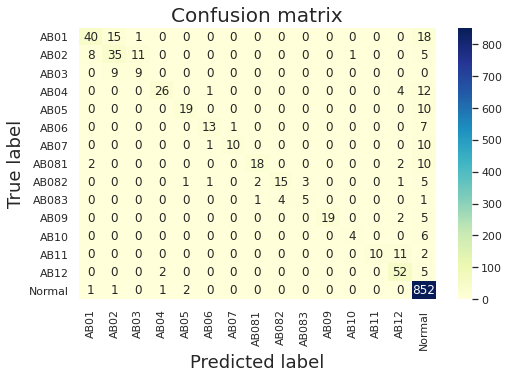

In [10]:
#create CF 
data = {'Actual': act,'Predicted' : pred,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act, pred)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

## Abn&Nor Class

In [11]:
act= data_train['Sub_class'].map({'AB12':1, 'AB04':1, 'AB05':1, 'Normal':0, 'AB02':1, 'AB11':1, 'AB082':1, 'AB06':1,'AB07':1, 'AB081':1, 'AB09':1, 'AB03':1, 'AB10':1, 'AB01':1, 'AB083':1}).values
pred = data_train['category'].map({'AB12':1, 'AB04':1, 'AB05':1, 'Normal':0, 'AB02':1, 'AB11':1, 'AB082':1, 'AB06':1,'AB07':1, 'AB081':1, 'AB09':1, 'AB03':1, 'AB10':1, 'AB01':1, 'AB083':1}).values
cmat = confusion_matrix(act, pred)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act, pred))#performance

classifier accuracy = 92.30182926829268%
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       857
           1       0.99      0.79      0.88       455

    accuracy                           0.92      1312
   macro avg       0.94      0.89      0.91      1312
weighted avg       0.93      0.92      0.92      1312



852 5 96 359


Text(0.5, 21.5, 'Predicted label')

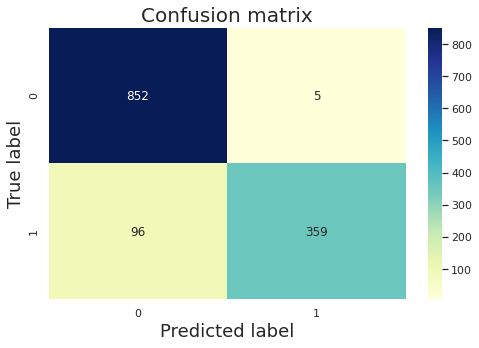

In [12]:
#create CF 
data = {'Actual': act,'Predicted' : pred,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act, pred)
TN, FP, FN, TP = confusion_matrix(act, pred).ravel()
print(TN, FP, FN, TP)
#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)